[Table of contents](../toc.ipynb)

# Calibration of a vehicle single track model

This notebook presents parameter estimation of a vehicle single track model given reference data from a double lane model of Simulink vehicle dynamics library.

The steps herein are similar to a recent paper of mine [[Rhode2019]](./references.bib), and you can find the according code to this paper on boschresearch at github: [https://github.com/boschresearch/iccve2019_valmon](https://github.com/boschresearch/iccve2019_valmon) if you are interested.

## Single track model

<img src="single-track-model.png" alt="single-track-model" width="400" align="right">

The vehicle single track model describes lateral vehicle dynamics accurately upon roughly 4 meters per square second lateral acceleration. The tires are merged into a single tire per axle, and the center of gravity is on same height as the track. Hence, just yaw is considered, no pitch or roll dynamics.

The state space form of the single track model is

\begin{equation*} \begin{bmatrix} \ddot{\psi}\\ \dot{\beta} \end{bmatrix}= \begin{bmatrix} -\frac{1}{v} \frac{c_{f} l_{v}^{2}+c_{r} l_{r}^{2}}{\Theta} & -\frac{c_{f} l_{f}-c_{r} l_{r}}{\Theta}\\ -1-\frac{1}{v^{2}} \frac{c_{f} l_{f}-c_{r} l_{r}}{m} & -\frac{1}{v} \frac{c_{f}+c_{r}}{m} \end{bmatrix} \begin{bmatrix} \dot{\psi}\\ \beta \end{bmatrix} + \begin{bmatrix} \frac{c_{f} l_{f}}{\Theta}\\ \frac{1}{v} \frac{c_{f}}{m} \end{bmatrix} \delta \end{equation*}

and you can find its derivation and more description in page 230 of [[Schramm2018]](./references.bib).

$\dot{\psi}$ denotes the yaw rate, $\beta$ the side slip angle, $c_{f,r}$ are the front and rear conering stiffness, $l_{f, r}$ front and rear distance from axle to center of gravity, $\Theta$ denotes the yaw inertia, $m$ the vehicle mass, $v$ the velocity, and $\delta$ denotes the wheel angle, which acts as model input.

## Double lane Simulink model

The reference data was generated with a standard double lane model in Simulink, which is presented in next figure.

<img src="double-lane-model.png" alt="double-lane-model" width="800">

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import control
from scipy.optimize import minimize

In [4]:
# This if else is a fix to make the file available for Jupyter and Travis CI
import os

def find_csv(filename):
    if os.path.isfile(filename):
        file = filename
    else:
        file = '04_mini-projects/' + filename
    return file

In [5]:
wheel_ang = np.genfromtxt(find_csv('wheel_angle.csv'), delimiter=",")
beta = np.genfromtxt(find_csv('beta.csv'), delimiter=",")
psi = np.genfromtxt(find_csv('psi.csv'), delimiter=",")

In [6]:
def plot_input__and_states(psi, beta, title):
    plt.figure()
    plt.plot(wheel_ang[1])
    plt.plot(psi)
    plt.plot(beta)
    plt.legend(["Wheel angle in rad", r"$\psi$ in rad per second", r"$\beta$ in rad",])
    plt.xlabel("time in seconds")
    plt.title("Double lane Simulink model")
    plt.show()    

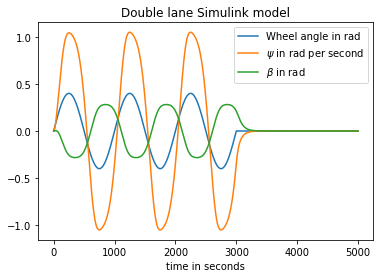

In [7]:
plot_input__and_states(psi=psi[1], beta=beta[1], title="Double lane Simulink model")

In [8]:
def single_track_model(c_f, c_r, l_f, l_r, m, theta, v):
    """
    Vehicle single track model from [p. 230, Schramm2018]
    states = [\dot{psi} in rad/s\\
              beta in rad]
    Args:
        c_f: Front cornering stiffness [N/rad]
        c_r: Rear cornering stiffness [N/rad]
        l_f: Distance CoG to front axles [m]
        l_r: Distance CoG to rear axles [m]
        m: Vehicle mass [kg]
        theta: Vehicle yaw inertia [kgm^2]
        v: Vehicle Speed [m/s]

    Returns:
        y: output vector
        x: sates
    """
    a_11 = -1 / v * (c_f * l_f ** 2 + c_r * l_r ** 2) / theta
    a_12 = -(c_f * l_f - c_r * l_r) / theta
    a_21 = -1 - 1 / (v ** 2) * (c_f * l_f - c_r * l_r) / m
    a_22 = -1 / v * (c_f + c_r) / m
    a_matrix = np.array([[a_11, a_12], [a_21, a_22]])

    b_1 = (c_f * l_f) / theta
    b_2 = 1 / v * c_f / m
    b_matrix = np.array([[b_1], [b_2]])

    c_matrix = np.array([[1, 0], [0, 1]])
    d_matrix = np.array([[0], [0]])

    return control.ss(a_matrix, b_matrix, c_matrix, d_matrix)

In [9]:
ss_model = single_track_model(c_f=12e3, c_r=11e3, l_f=1.4, l_r=1.6, m=2000, theta=4000, v=10)

y, x = control.forced_response(ss_model, T=wheel_ang[0], U=wheel_ang[1], X0=np.array([0, 0]))[1:3]

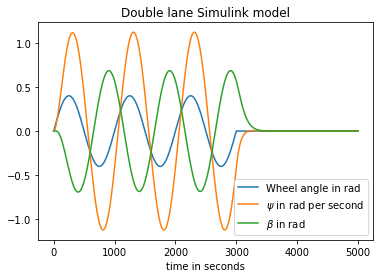

In [10]:
plot_input__and_states(psi=y[0], beta=y[1], title="Single track model")

In [11]:
def objective_func(x):    
    ss_model = single_track_model(c_f=x[0], c_r=x[1], l_f=1.4, l_r=1.6, m=2000, theta=4000, v=10)
    
    y, x = control.forced_response(ss_model, T=wheel_ang[0], U=wheel_ang[1], X0=np.array([0, 0]))[1:3]

    err0 = psi[1] - y[0]
    err1 = beta[1] - y[1]

    scaled_err0 = (err0 - np.min(err0)) / (np.max(err0) - np.min(err0))
    scaled_err1 = (err1 - np.min(err1)) / (np.max(err1) - np.min(err1))

    objective = np.sum(scaled_err0 ** 2) + np.sum(scaled_err1 ** 2)
    return objective

In [12]:
def parameter_fitting():
    x0 = np.array([11e3, 11e3])
    res = minimize(fun=objective_func, x0=x0,
                   method='Powell', options={'disp': True})
    print("Optimized params")
    print(res.x)
    return res.x

In [13]:
optimized_params = parameter_fitting()

Optimization terminated successfully.
         Current function value: 2858.222914
         Iterations: 2
         Function evaluations: 63
Optimized params
[11130.32243675 11054.74421437]


In [14]:
ss_model = single_track_model(c_f=11130, c_r=11054, l_f=1.4, l_r=1.6, m=2000, theta=4000, v=10)

y, x = control.forced_response(ss_model, T=wheel_ang[0], U=wheel_ang[1], X0=np.array([0, 0]))[1:3]

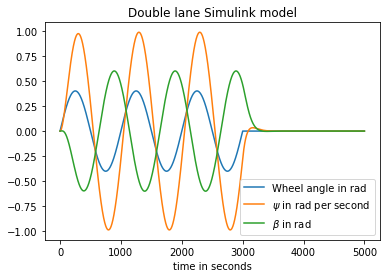

In [15]:
plot_input__and_states(psi=y[0], beta=y[1], title="Optimized single track model")

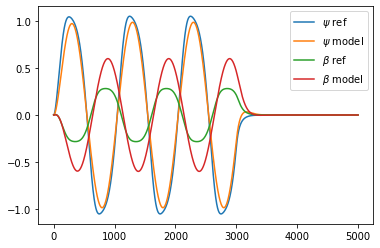

In [16]:
plt.figure()
plt.plot(psi[1])
plt.plot(y[0])
plt.plot(beta[1])
plt.plot(y[1])
plt.legend([r"$\psi$ ref", r"$\psi$ model", r"$\beta$ ref", r"$\beta$ model"])
plt.show()
